<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-1

In [1]:
#@title Current Date
Today = '2021-08-22' #@param {type:"date"}


In [2]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "" #@param {type:"string"}
Student_full_name = "" #@param {type:"string"}
#@markdown ---

In [3]:
#@title Notebook information
Notebook_type = 'Example' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Draft' #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

## MNIST dataset



The MNIST database  is a dataset of handwritten digits that has been and is extensively used in machine learning. There are $10$ classes, each image is $28\times28$ pixels and, therefore, each input is $x_i\in\mathbb{R}^{784}$. 

## Task

You have to extend the code to manage any arbitrary number of classes, in other words you have to implement a general-recipe multinomial logistic classifier and Bayesian multinomial logistic classifier.

You must then select  3 digits at random and perform  the following task. 

1. Your goal is to use Bayesian multinomial logistic regression (as in the road-sign notebook) to solve this classification problem. 

2. You can downsize the training dataset (e.g., 40% training and 60%testing) if the computation of the posterior takes too much time in your computer.

3. Use the posterior uncertainty to detect the instances (digits) in the test set that are hard to classify and remove them from the test-set.

4. Then you need to compute again the accuracy of the general-recipe logistic regression on the remaining (non-difficult) instances and comment on the result.

5. In practice, the task is to use uncertainty estimation to detect the difficult instances in the test-set. This is equivalent to refuse to classify all high-uncertainty instances or, in other words, when we are uncertain we say "I don't know" and we do not return any class. In this way, you will learn how uncertainty can be used to make safer decisions, by detecting the instances that are difficult to classify.


## Libraries

In [4]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import scipy.optimize as optimize
from scipy.special import erf
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from skimage.io import imread, imshow
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import arviz as az
from scipy.io import loadmat
import pymc3 as pm
import random
from IPython.display import HTML
import pickle
import theano as tt
import cv2
from sklearn.utils import shuffle
from skimage.color import rgb2gray


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [6]:
# Setting a seed:
np.random.seed(123)

#### Any functions needed/used later on.

In [7]:
def normalize(img):
    return cv2.normalize(img, img, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    

def grayscale(img):
    #COLOR_BGR2GRAY COLOR_RGB2GRAY
    return rgb2gray(img)
    #return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  

def setgrayscale(images):
    #from rgb to gray
    print(images.shape)
    result = np.zeros(shape=(len(images),32,32))
    for i in range(len(images)): 
        #gray = np.resize(grayscale(images[i]), (32, 32, 1))
        gray_img = grayscale(images[i])
        img_normalized = normalize(gray_img)
        result[i] = gray_img
    print(result.shape)
    return result

# Plot digits as 28x28 size
def plot_digits(instances, images_per_row=5, **options):
    
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image,  cmap='gist_yarg', **options)
    plt.axis("off")

## Dataset

The MINST (Modified National Institute of Standards and Technology) (http://yann.lecun.com/exdb/mnist/) dataset is a collection of handwritten digits with 60,000 examples and 10,000 training sets.

### Loading the MNIST dataset

Load from either google colab or from local disk. For now local disk is easier for me.

In [8]:
#from google.colab import drive

RunningInCOLAB = 'google.colab' in str(get_ipython())

if RunningInCOLAB:
    drive.mount('/content/drive')
    
    # Path, copy the path from your Drive
    Path = '/content/drive/MyDrive/Colab Notebooks/Enrique/Data/'

    # MNIST Data
    train_data = Path + 'mnist_train.csv'
    test_data = Path + 'mnist_test.csv'

In [9]:

# MNIST CSV Data from sharepoint
train_data = './mnist_train.csv'
test_data = './mnist_test.csv'

# Below won't work as the type is a dictionary (no drop() method) and not a DataFrame
# Train data
df_train = pd.read_csv(train_data)
print(type(df_train))
print(df_train)

# From Morgan Lynch
X_train = df_train.iloc[: , 1:] #df_train.drop("label",axis=1).values
y_train = df_train.iloc[:, 0] #df_train.label.values
#print(X_train)

#X_train = df_train.drop("label",axis=1).values
#y_train = df_train.label.values
print(X_train.shape)

# test data
df_test = pd.read_csv(test_data)
X_test = df_test.iloc[: , 1:]
y_test = df_test.iloc[:, 0]

#X_test = df_test.drop("label",axis=1).values
#y_test = df_test.label.values
print(X_test.shape)
image_dimension = int(np.sqrt(X_test.shape[1]))
print("Using {} as image dimension".format(image_dimension))


<class 'pandas.core.frame.DataFrame'>
       5  0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  ...  0.608  0.609  0.610  \
0      0  0    0    0    0    0    0    0    0    0  ...      0      0      0   
1      4  0    0    0    0    0    0    0    0    0  ...      0      0      0   
2      1  0    0    0    0    0    0    0    0    0  ...      0      0      0   
3      9  0    0    0    0    0    0    0    0    0  ...      0      0      0   
4      2  0    0    0    0    0    0    0    0    0  ...      0      0      0   
...   .. ..  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...    ...    ...   
59994  8  0    0    0    0    0    0    0    0    0  ...      0      0      0   
59995  3  0    0    0    0    0    0    0    0    0  ...      0      0      0   
59996  5  0    0    0    0    0    0    0    0    0  ...      0      0      0   
59997  6  0    0    0    0    0    0    0    0    0  ...      0      0      0   
59998  8  0    0    0    0    0    0    0    0    0  ...      0      0 

In [10]:
# Normalizing the Inputs:
X_train = X_train/255
X_test = X_test/255

# Printing the new input range of values:
minv = np.min(X_train)
maxv = np.max(X_train)
print(minv,maxv)

0        0.0
0.1      0.0
0.2      0.0
0.3      0.0
0.4      0.0
        ... 
0.613    0.0
0.614    0.0
0.615    0.0
0.616    0.0
0.617    0.0
Length: 784, dtype: float64 0        0.000000
0.1      0.000000
0.2      0.000000
0.3      0.000000
0.4      0.000000
           ...   
0.613    0.243137
0.614    0.000000
0.615    0.000000
0.616    0.000000
0.617    0.000000
Length: 784, dtype: float64


### Description of Data:

#### I want to visualise the types of images we are dealing with.

The code below is from https://github.com/iamkrut/MNIST_handwriting_classification/blob/master/main.py and reads the raw data from the MINST site. It will create a ./data/MNIST/raw directory with the following files:

* `t10k-images-idx3-ubyte`
* `t10k-labels-idx1-ubyte`
* `train-images-idx3-ubyte`
* `train-labels-idx1-ubyte`
* `t10k-images-idx3-ubyte.gz`
* `t10k-labels-idx1-ubyte.gz`
* `train-images-idx3-ubyte.gz`
* `train-labels-idx1-ubyte.gz`


<class 'torchvision.datasets.mnist.MNIST'>


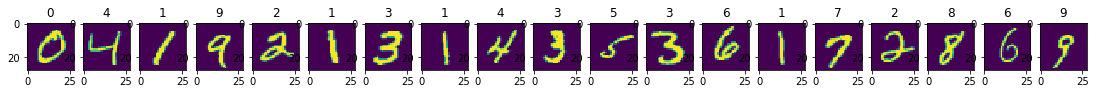

In [11]:
# For displaying the images
import torch
from torchvision import transforms
import torchvision.datasets as datasets

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True,
                                transform=transforms.Compose([transforms.ToTensor()]))

print(type(mnist_trainset))

# Show some of the images/data
number_to_print = 20
fig=plt.figure(figsize=(20, 12))

for i in range(1, number_to_print):
    
    img = transforms.ToPILImage(mode='L')(mnist_trainset[i][0])
    fig.add_subplot(1, number_to_print, i)
    plt.title(mnist_trainset[i][1])
    plt.imshow(img)
    
plt.show()

They appear to be simpler than the traffic light examples, so do we still need to use grayscale versions of them ?

In [12]:
# Number of examples
n_train = len(X_train)
n_test = len(X_test)

# Shape of an traffic sign image
image_shape = X_train.shape[1]
print(X_train.shape)

# unique classes/labels in the training dataset.
alltotal = set(y_train)
n_classes = len(alltotal)

print("Number of Training examples =", n_train)
print("Number of Test examples =", n_test)
print("Image input shape =", image_shape)
print("Number of classes =", n_classes)
print("Test data shape {}".format(X_test.shape[1]))

(59999, 784)
Number of Training examples = 59999
Number of Test examples = 9999
Image input shape = 784
Number of classes = 10
Test data shape 784


### Class Distribution:

Each 'class' represents a different digit and there are 10 different types in the dataset (0 -> 9)

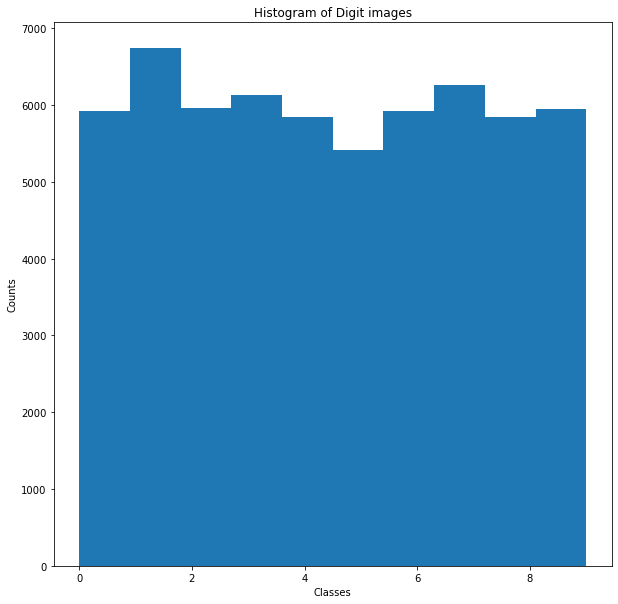

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
ind = np.arange(n_classes)

n, bins, patches = ax.hist(y_train, n_classes)
ax.set_xlabel('Classes')
ax.set_ylabel('Counts')
ax.set_title(r'Histogram of Digit images')
plt.show()

## Downsampling

### Randomly selecting 3 of the 10 Digit Classes

In [14]:
# We select the number of Classes we want:
n_classes = 3

# Empty list to append the random digit classes we select:
classes = []

# We select 3 digits at random and make sure they are unique:
while len(classes) < n_classes:
    
    # Randomly drawing a digit from 0-9:
    num2choose = np.random.randint(0,10)    

    # Append the digit if it's not already in our list of classes:    
    if num2choose not in classes:        
        classes.append(num2choose)
        
print("Unorted classes {}".format(classes))

# Sorting the Classes smallest to largest    
classes.sort()

# print classes selected
print("Sorted classes {}".format(classes))

Unorted classes [2, 6, 1]
Sorted classes [1, 2, 6]


Numpy where(condition[, x, y]) - return values from x or y depending on condition, so for below where r is in the training set, use [0], otherwise use the whole list.
Got some assistance on the slice error from https://stackoverflow.com/questions/55291667/getting-typeerror-slicenone-none-none-0-is-an-invalid-key

In [15]:
# The number of instances we'll keep for each of our 3 digits:
inst_class = 100

inputs = []
labels = []

print(type(X_train))

# Loop to randomly sample the instances for each digit:
for r in classes:

    #print(np.where(y_train==r)[0],X_train[:])

    # This was failing when using the csv files with 60k entries
    #  (array([    2,     5,     7, ..., 59978, 59983, 59993]), slice(None, None, None))' is an invalid key
    # The ,:] is the slice - why are the values None ?
    # Slice is a[start:stop:step]
    imgs = X_train.iloc[np.where(y_train==r)[0], :].values
    print("Using class {}, curr image shape {}".format(r, imgs.shape))
    #print(imgs)
    inputs.append(imgs[np.random.permutation(imgs.shape[0]),:][0:inst_class,:])
    labels.append(np.ones(inst_class)*r)
    
print("Labels {}".format(labels))

# Shaping inputs and labels in the right format. vstack, alters the contents to be vertical
# So from ([1, 2, 3])
#    to array([[1],
#              [2],
#              [3]])
X_train = np.vstack(inputs).astype(np.float64)
y_train = np.hstack(labels)
print("Xtrain type is now {}".format(type(X_train)))

#------------------------- 
# The imgs has a shpe of 784
#plt.figure(figsize=(8,8))
#print(imgs)

# Plotting 'original' image
#plot_digits(imgs,images_per_row=5) # images_per_row was set to 9
#plt.title("Original", fontsize=14)

<class 'pandas.core.frame.DataFrame'>
Using class 1, curr image shape (6742, 784)
Using class 2, curr image shape (5958, 784)
Using class 6, curr image shape (5918, 784)
Labels [array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
   

In [16]:
print(inputs)

print(X_train)
print(y_train)

[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

New Classes Distribution

In [17]:
# new histogram

The plot function is using 28*28 which is means 784 is required as the size of the array

In [18]:
# Show a few instances from each Digit:
#plt.figure(figsize=(8,8))

# Selecting a few label indices from each of the 3 classes to show:
#label_indices = 2

# Plotting 'original' image
#plot_digits(X_train[label_indices,:],images_per_row=1) # images_per_row was set to 9
#plt.title("Original", fontsize=14)

###  Splitting the Training data into both Training and Validation Sets:

- Although this is the Training set, we can still set aside some samples (for instance 20%) of the 1,500 instances we have for Model Validation purposes.


- With that Validation Set, we can then select the amount of Uncertainty we are happy with from our Model to use out of sample on other unseen data.


- We can then test out how well our decision performs on the Test Set that we put aside earlier.

In [19]:
### Split tha dataset in training and validation sets
# choose the fraction of your validation data from the training set
w = 0.20
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=w, random_state=0)
 
# Shuffling the training instaces around to randomize the order of inputs to the model:
X_train_shuf, y_train_shuf = shuffle(X_train, y_train)

### Print shape of your validation and training set
This needs to be minimum of 3 for the numpy.flatten() to work.

In [20]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(240, 784)
(60, 784)
(240,)
(60,)


Transforming images into vectors (vectorization or tracing) is the process of taking a bitmap image and re-drawing it as a vector image (1-D). The shapes in vector images will then enable you to do run various computations that cannot be done with bitmap images, such as scale them to any size without loss of quality.
Not flattening for now as already in 2-D.

In [21]:
# Transform images into vectors (1-dimension)
# X_train only has 24 x 784 so [2] is going to be out of range
# Similar to the traffic light example, what do I need to get the correct shape here ?

#X_train_vect = X_train.flatten().reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
#X_val_vect = X_val.flatten().reshape(X_val.shape[0], X_train.shape[1]*X_train.shape[2])

#print(X_train_vect.shape)
#print(X_val_vect.shape)
#print(y_train.shape)
#print(y_val.shape)

### Encoding the Class labels for the Probabilistic ML Model:

This is an example:

- **[1,0,0]** for first digit
- **[0,1,0]** for second digit
- **[0,0,1]** for third digit

### General-Recipe ML
* Using an integer for `random_state` will produce the same results each time
* `max_iter` - max number of iterations
* `C` 
* `solver` is the optimisation algorithm to use
* `multi_class` if you are using more than 2 classes

In [22]:
# General-recipe ML Multinomial logistic regression
gen_model_log = LogisticRegression(random_state=0,
                         max_iter=2000,
                         C=100,
                         solver='lbfgs',
                         multi_class='multinomial').fit(X_train, y_train_shuf)

# Classification:
y_pred_logi = gen_model_log.predict(X_val)
y_pred_logi_prob = gen_model_log.predict_proba(X_val)

prob_classmax = np.max(y_pred_logi_prob, axis=1)

# Computing the Accuracy:
print("Accuracy=", accuracy_score(y_pred_logi, y_val))

Accuracy= 0.23333333333333334


In [23]:
np.sort(prob_classmax)

array([0.45351569, 0.46044005, 0.53430154, 0.55983286, 0.58829759,
       0.62462322, 0.65891207, 0.7043971 , 0.71085616, 0.74155852,
       0.74608752, 0.76575644, 0.7929069 , 0.81196953, 0.81868823,
       0.83193704, 0.84855954, 0.86069135, 0.87355958, 0.88010199,
       0.89798311, 0.9027083 , 0.90482586, 0.90809396, 0.91055414,
       0.91539879, 0.93303106, 0.94319468, 0.94435683, 0.95898014,
       0.96605543, 0.98371974, 0.98555988, 0.98672781, 0.99091748,
       0.99325722, 0.99566208, 0.99651147, 0.99766145, 0.99821686,
       0.99847612, 0.99889466, 0.99929753, 0.99939354, 0.99957882,
       0.99971775, 0.99976632, 0.99982863, 0.99991468, 0.99992745,
       0.99992805, 0.99993185, 0.99996221, 0.99996768, 0.99998608,
       0.99999637, 0.99999851, 0.99999967, 0.9999997 , 0.99999987])

In [24]:
# probability of general-recipe logistic regression in wrong instances
prob_classmax[y_pred_logi!=y_val]

array([0.94319468, 0.62462322, 0.99889466, 0.81196953, 0.99971775,
       0.96605543, 0.55983286, 0.99996221, 0.45351569, 0.88010199,
       0.99939354, 0.99992805, 0.84855954, 0.99992745, 0.99091748,
       0.76575644, 0.99999637, 0.98371974, 0.99976632, 0.7043971 ,
       0.99999967, 0.99929753, 0.71085616, 0.91055414, 0.99999987,
       0.93303106, 0.81868823, 0.74155852, 0.99847612, 0.99325722,
       0.99998608, 0.58829759, 0.9027083 , 0.99991468, 0.74608752,
       0.90482586, 0.91539879, 0.83193704, 0.98672781, 0.99766145,
       0.99566208, 0.53430154, 0.89798311, 0.65891207, 0.99993185,
       0.99996768])

In [25]:
np.array(y_pred_logi)

array([1., 6., 2., 2., 2., 2., 1., 6., 1., 6., 2., 6., 2., 2., 2., 1., 2.,
       2., 6., 6., 2., 6., 2., 6., 2., 2., 6., 2., 2., 1., 6., 6., 6., 1.,
       6., 6., 1., 1., 2., 6., 1., 1., 2., 6., 6., 2., 2., 2., 2., 6., 6.,
       2., 2., 2., 2., 2., 6., 6., 1., 1.])

### Probabilistic Multinomial Logistic Regression:

The Multinomial Logistic Regression has some parameters:

- $\alpha$, which is the intercept term:

- $\beta$, which is a vector of coefficients which give a weighting to the importance of each input feature:

Using PyMC3 to build a model.

In [26]:
import sklearn.preprocessing

# We use LabelBinarizer to transfor classes into counts
# neg_label=0, pos_label=1

y_2_bin = sklearn.preprocessing.LabelBinarizer().fit_transform(y_train_shuf.reshape(-1,1))
nf = X_train_shuf.shape[1]

# number of classes
nc = len(classes)

# floatX = float32
floatX = tt.config.floatX

init_b = np.random.randn(nf, nc-1).astype(floatX)
init_a = np.random.randn(nc-1).astype(floatX)


with pm.Model() as bay_multi_logistic:
    
    # Prior
    β = pm.Normal('beta', 0, sigma=100, shape=(nf, nc-1), testval=init_b)
    α = pm.Normal('alpha', 0, sigma=100, shape=(nc-1,), testval=init_a)
    
    # we need to consider nc-1 features because the model is not identifiable
    # the softmax turns a vector into a probability that sums up to one
    # therefore we add zeros to go back to dimension nc
    # so that softmax returns a vector of dimension nc
    β1  = tt.tensor.concatenate([np.zeros((nf,1)),β ],axis=1)
    α1  = tt.tensor.concatenate([[0],α ],)
    
    # Likelihood
    mu = pm.math.matrix_dot(X_train_shuf, β1) + α1
    
    # It doesn't work if the problem is binary
    p = tt.tensor.nnet.nnet.softmax(mu)
    observed = pm.Multinomial('likelihood', p=p, n=1, observed=y_2_bin)


In [27]:
print(y_2_bin)

[[0 1 0]
 [0 1 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 

#### Test with different number of itterations
https://docs.pymc.io/notebooks/variational_api_quickstart.html
    
* `advi` is automatic differentiation variational inference. This automatically derives an efficient variational inference algorithm.

Finished [100%]: Average Loss = 6,716


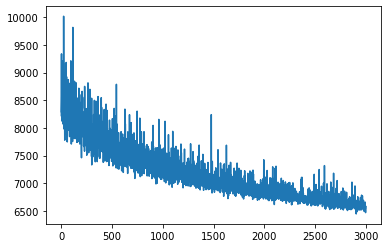

In [28]:
with bay_multi_logistic:
    approx3k = pm.fit(3000, method='advi')

plt.plot(approx3k.hist)

Finished [100%]: Average Loss = 6,254.3


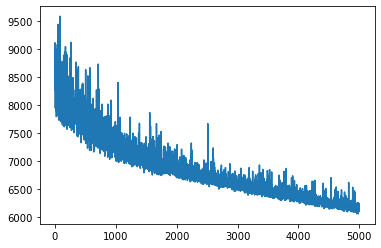

In [29]:
with bay_multi_logistic:
    approx5k = pm.fit(5000, method='advi')
    
plt.plot(approx5k.hist)

Finished [100%]: Average Loss = 5,488


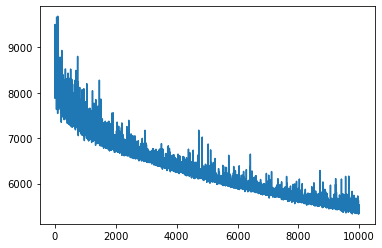

In [30]:
with bay_multi_logistic:
    approx10k = pm.fit(10000, method='advi')
    
plt.plot(approx10k.hist)

Finished [100%]: Average Loss = 4,133.9


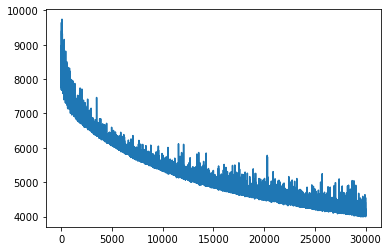

In [31]:
with bay_multi_logistic:
    approx30k = pm.fit(30000, method='advi')

plt.plot(approx30k.hist)

Finished [100%]: Average Loss = 2,834.2


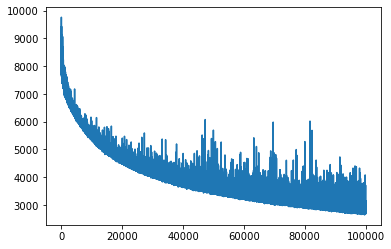

In [47]:
with bay_multi_logistic:
    approx100k = pm.fit(100000, method='advi')

plt.plot(approx100k.hist)

In [48]:
dd = 300
posterior = approx100k.sample(draws=dd)

test image #10
posterior sample #100
true class= 6.0
classes: [1, 2, 6]
estimated prob= [0. 0. 1.]


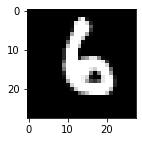

In [49]:
## The softmax function transforms each element of a collection by computing the exponential
#  of each element divided by the sum of the exponentials of all the elements.
from scipy.special import softmax

# select an image in the test set
i = 10 
#i = random.randint(0, dd)

# select a sample in the posterior
s = 100 
#s = random.randint(0, dd)

beta  = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
alpha = np.hstack([[0],  posterior['alpha'][s,:] ])
# image = X_valv[i,:].reshape(32,32) - this is from the flatten() call
image = X_val[i,:].reshape(image_dimension, image_dimension)

plt.figure(figsize=(2,2))
plt.imshow(image, cmap="Greys_r")
np.set_printoptions(suppress=True)

print("test image #" + str(i))
print("posterior sample #" + str(s))
print("true class=", y_val[i])
print("classes: " + str(classes))
print("estimated prob=",softmax((np.array([X_val[i,:].dot(beta) + alpha])))[0,:])

In [50]:
# Bayesian prediction
# return the class that has the highest posterior probability
y_pred_Bayesian=[]

for i in range(X_val.shape[0]):
    val=np.zeros((1,len(classes)))
    
    for s in range(posterior['beta'].shape[0]):
        beta = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])     
        val = val + softmax((np.array([X_val[i,:].dot(beta) + alpha])))
    
    mean_probability = val/posterior['beta'].shape[0]
    y_pred_Bayesian.append( np.argmax(mean_probability))

In [51]:
print(y_pred_Bayesian)

[2, 1, 0, 1, 2, 1, 2, 2, 0, 1, 2, 0, 1, 2, 0, 0, 1, 0, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 0, 0, 0, 1, 2, 1, 1, 1, 2, 0, 2, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 2, 1, 1, 0, 2, 1, 0, 2, 1]


In [52]:
# recall the classes we are using
print(classes)

[1, 2, 6]


In [53]:
# prediction array (using classes)
nn = 10 # just an example
np.array(classes)[y_pred_Bayesian[0:nn]]

array([6, 2, 1, 2, 6, 2, 6, 6, 1, 2])

In [54]:
# using validation: y_val
print("Accuracy=", accuracy_score(np.array(classes)[y_pred_Bayesian], y_val))

Accuracy= 0.9166666666666666


In [55]:
y_predB=[]

for i in range(X_val.shape[0]):
    #print(i)
    val=[]

    for s in range(posterior['beta'].shape[0]):
        beta = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])
        val.append(softmax((np.array([X_val[i,:].dot(beta) + alpha])))[0,:])

    # mean probability
    valmean = np.mean(val,axis=0)
    
    # class with maximum mean probability
    classmax = np.argmax(valmean)
    
    # ranks
    ranks = np.array(val.copy())
    ranks   = ranks  *0 #init
    colmax = np.argmax(np.array(val),axis=1)
    ranks[np.arange(0,len(colmax)),colmax]=1
     
    y_predB.append( [classmax, valmean[classmax], np.std(ranks,axis=0)[classmax]])

    
y_predB= np.array(y_predB)

In [56]:
# prediction array
mm = 10
y_predB[0:mm,:]

array([[2.        , 0.78085655, 0.41197357],
       [1.        , 0.95797535, 0.20360637],
       [0.        , 0.99999993, 0.        ],
       [1.        , 0.61910841, 0.4861984 ],
       [2.        , 1.        , 0.        ],
       [1.        , 0.90268635, 0.3       ],
       [2.        , 0.88235547, 0.32102267],
       [2.        , 1.        , 0.        ],
       [0.        , 0.99182426, 0.08137704],
       [1.        , 0.63126494, 0.48280431]])

In [57]:
# sorting in descending order

difficult = np.argsort(-y_predB[:,2])
y_predB[difficult[0:mm],:]

array([[0.        , 0.58019268, 0.49459299],
       [0.        , 0.59173935, 0.49183331],
       [1.        , 0.61910841, 0.4861984 ],
       [1.        , 0.6252807 , 0.48455019],
       [1.        , 0.63126494, 0.48280431],
       [2.        , 0.78085655, 0.41197357],
       [1.        , 0.78447893, 0.40966111],
       [1.        , 0.82176311, 0.38418745],
       [2.        , 0.85028761, 0.35707142],
       [1.        , 0.87968938, 0.32881944]])

In [58]:
# Probability of general-recipe logistic regression in wrong instances

prob_classmax[y_pred_logi != y_val]

array([0.94319468, 0.62462322, 0.99889466, 0.81196953, 0.99971775,
       0.96605543, 0.55983286, 0.99996221, 0.45351569, 0.88010199,
       0.99939354, 0.99992805, 0.84855954, 0.99992745, 0.99091748,
       0.76575644, 0.99999637, 0.98371974, 0.99976632, 0.7043971 ,
       0.99999967, 0.99929753, 0.71085616, 0.91055414, 0.99999987,
       0.93303106, 0.81868823, 0.74155852, 0.99847612, 0.99325722,
       0.99998608, 0.58829759, 0.9027083 , 0.99991468, 0.74608752,
       0.90482586, 0.91539879, 0.83193704, 0.98672781, 0.99766145,
       0.99566208, 0.53430154, 0.89798311, 0.65891207, 0.99993185,
       0.99996768])

In [59]:
y_predB[y_pred_logi != y_val,:]

array([[2.        , 0.78085655, 0.41197357],
       [1.        , 0.95797535, 0.20360637],
       [0.        , 0.99999993, 0.        ],
       [1.        , 0.61910841, 0.4861984 ],
       [2.        , 1.        , 0.        ],
       [2.        , 0.88235547, 0.32102267],
       [1.        , 0.63126494, 0.48280431],
       [2.        , 0.99260058, 0.08137704],
       [0.        , 0.99331453, 0.08137704],
       [2.        , 1.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [1.        , 0.90364681, 0.29550334],
       [0.        , 0.98021802, 0.14      ],
       [1.        , 0.94111567, 0.23748684],
       [1.        , 0.98920015, 0.09949874],
       [1.        , 0.98697783, 0.11469767],
       [2.        , 0.99999822, 0.        ],
       [1.        , 0.93717171, 0.24356154],
       [2.        , 1.        , 0.        ],
       [2.        , 0.99999998, 0.        ],
       [1.        , 0.78447893, 0.40966111],
       [0.        , 0.99507972, 0.08137704],
       [0.

 #### Difficult & easy instances

In [60]:

easy = np.argsort(y_predB[:,2])
print("Accuracy in easy instances =", accuracy_score(y_pred_logi[easy[0:100]],
                                                     y_val[easy[0:100]]))

difficult = np.argsort(-y_predB[:,2])
print("Accuracy in difficult instances =", accuracy_score(y_pred_logi[difficult[0:100]],
                                                          y_val[difficult[0:100]]))

Accuracy in easy instances = 0.23333333333333334
Accuracy in difficult instances = 0.23333333333333334


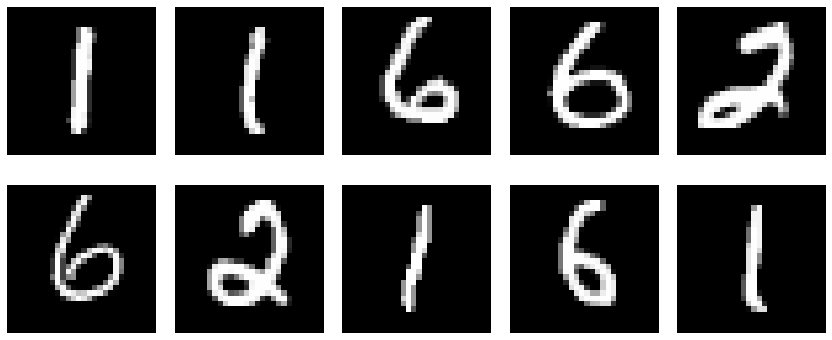

In [61]:
# Show 10 random 'easy' images
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in range(10):
    index = easy[i]
    image = X_val[index,:].reshape(image_dimension, image_dimension)
    axs[i].axis('off')
    axs[i].imshow(image,cmap="Greys_r")

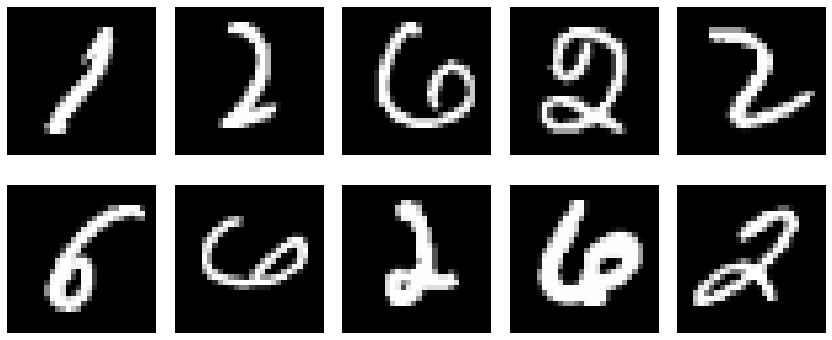

In [62]:
# Show 10 random 'difficult' images
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in range(10):
    index = difficult[i]
    image = X_val[index,:].reshape(image_dimension, image_dimension)
    axs[i].axis('off')
    axs[i].imshow(image,cmap="Greys_r")

## Summary

Populate this section with all of your findings and comments fron the discussion with your peers.

As I understand it, the etivity ask is to use posterior probability (Bayes - which is an adjustment on prior probability) which is the probability of an outcome given we have new information, to be able classify multiple types of events (not just true/false, events being hand written digits in this case) for the MINST dataset and it is multinomial because the MINST dataset is a set of handwritten digits from 0 - 9 ? and not just a set of 2 digits.

## References
### Websites
#### https://en.wikipedia.org/wiki/Maximum_likelihood_estimation
#### https://en.wikipedia.org/wiki/Posterior_probability
#### https://towardsdatascience.com/probability-concepts-explained-maximum-likelihood-estimation-c7b4342fdbb1
#### https://towardsdatascience.com/a-gentle-introduction-to-maximum-likelihood-estimation-9fbff27ea12f
#### https://towardsdatascience.com/introduction-to-bayesian-logistic-regression-7e39a0bae691
#### https://statquest.org/
#### http://docs.zeligproject.org/articles/zelig_mlogitbayes.html
#### https://pandas.pydata.org/docs/reference/api/pandas.read_pickle.html
#### https://www.statisticshowto.com/
#### https://www.mathsisfun.com/sets/symbols.html
#### https://docs.pymc.io/

### Books/Papers
#### Salvatier J., Wiecki T.V., Fonnesbeck C. (2016) Probabilistic programming in Python using PyMC3. PeerJ Computer Science 2:e55 DOI: 10.7717/peerj-cs.55.
#### Statistics by David W.H. Swenson - http://www.cchem.berkeley.edu/chem120a/extra/statistics.pdf
#### Automatic Differentiation Variational Inference https://arxiv.org/pdf/1603.00788.pdf